/home/arun/.local/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


269


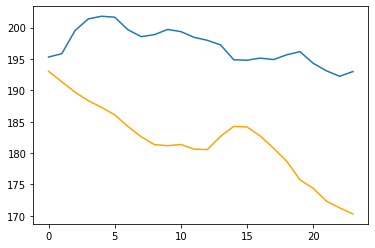

In [12]:
import pandas

#load Insulin and CGM Data
insulinDf = pandas.read_csv('InsulinAndMealIntake670GPatient3.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]
cgmDf = pandas.read_csv('CGMData670GPatient3.csv', parse_dates=[['Date','Time']],low_memory=False).iloc[::-1]

cgmDf

#filter NaNs and Zeros
insulinDFColY = insulinDf[insulinDf['BWZ Carb Input (grams)'].notnull() & insulinDf['BWZ Carb Input (grams)'] != 0]
insulinMealDates = pandas.DataFrame(insulinDFColY['Date_Time'])
insulinMealDates

#mealStartDates from Insulin CSV
insulinMealDates['Diff'] = insulinMealDates.iloc[:,0].diff(-1).dt.total_seconds().div(3600)
insulinMealDates = insulinMealDates.loc[insulinMealDates['Diff'] <= -2]
insulinNoMealDates = insulinMealDates.loc[insulinMealDates['Diff'] <= -4]
insulinMealDates.drop(insulinMealDates.head(1).index,inplace=True)
insulinMealDates.drop(insulinMealDates.tail(2).index,inplace=True)
insulinNoMealDates.drop(insulinNoMealDates.head(1).index,inplace=True)
insulinNoMealDates.drop(insulinNoMealDates.tail(2).index,inplace=True)
insulinNoMealDates

mealDatesList = []
for ind in insulinMealDates.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    mealDatesList.append((cgmDf.loc[cgmDf['Date_Time'] >= insulinMealDates['Date_Time'][ind]])['Date_Time'].iloc[0])
mealDatesList

noMealDatesList = []
for ind in insulinNoMealDates.index: 
#     print("InsulinMealData : " + str(insulinMealDates['Date_Time'][ind]))
    noMealDatesList.append((cgmDf.loc[cgmDf['Date_Time'] >= insulinNoMealDates['Date_Time'][ind]])['Date_Time'].iloc[0])
noMealDatesList

cgmDf.shape[0]

mealDataMatrix = []
for mealDateTime in mealDatesList:
    idx = cgmDf[cgmDf['Date_Time'] == mealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    mealDataMatrix.append(list(cgmDf['Sensor Glucose (mg/dL)'].iloc[cgmDf.shape[0]-1-idx:cgmDf.shape[0]-1-idx+24].values))
mealDataMatrix

noMealDataMatrix = []
for noMealDateTime in noMealDatesList:
    idx = cgmDf[cgmDf['Date_Time'] == noMealDateTime]['Sensor Glucose (mg/dL)'].index[0]
    noMealDataMatrix.append(list(cgmDf['Sensor Glucose (mg/dL)'].iloc[cgmDf.shape[0]-1-idx+24:cgmDf.shape[0]-1-idx+48].values))

# idx = cgmDf['Date_Time'].loc[lambda x: x=='2017-07-28 21:39:14'].index
# idx
# (cgmDf.iloc[idx[0] - 24 : idx[0] + 6])['Sensor Glucose (mg/dL)']

mealDf = pandas.DataFrame(mealDataMatrix).dropna()
mealDfAvg = mealDf.mean(axis=0)
mealDfAvg

noMealDf = pandas.DataFrame(noMealDataMatrix).dropna()
print(noMealDf.shape[0])
noMealDfAvg = noMealDf.mean(axis=0)
noMealDfAvg

import matplotlib.pyplot as plt
plt.plot(mealDfAvg)
plt.plot(noMealDfAvg,color='orange')
plt.show()

#Training sequential data using LSTM


In [10]:
mealDf

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,131.0,132.0,130.0,128.0,127.0,128.0,129.0,126.0,122.0,120.0,...,145.0,156.0,162.0,170.0,180.0,191.0,201.0,212.0,219.0,223.0
1,165.0,163.0,160.0,157.0,161.0,177.0,185.0,187.0,192.0,190.0,...,163.0,148.0,136.0,127.0,122.0,130.0,140.0,150.0,156.0,157.0
2,103.0,108.0,117.0,123.0,128.0,132.0,137.0,141.0,142.0,142.0,...,192.0,186.0,176.0,160.0,161.0,168.0,180.0,206.0,209.0,207.0
3,168.0,163.0,157.0,161.0,168.0,185.0,190.0,196.0,202.0,211.0,...,230.0,224.0,220.0,217.0,208.0,197.0,197.0,203.0,201.0,193.0
4,127.0,127.0,124.0,121.0,116.0,113.0,114.0,115.0,115.0,114.0,...,107.0,110.0,108.0,99.0,87.0,78.0,76.0,82.0,87.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,162.0,160.0,159.0,158.0,159.0,159.0,159.0,159.0,159.0,161.0,...,164.0,159.0,150.0,138.0,132.0,130.0,130.0,129.0,127.0,125.0
388,162.0,160.0,159.0,158.0,159.0,159.0,159.0,159.0,159.0,161.0,...,164.0,159.0,150.0,138.0,132.0,130.0,130.0,129.0,127.0,125.0
389,162.0,160.0,159.0,158.0,159.0,159.0,159.0,159.0,159.0,161.0,...,164.0,159.0,150.0,138.0,132.0,130.0,130.0,129.0,127.0,125.0
390,264.0,261.0,257.0,253.0,247.0,242.0,234.0,225.0,195.0,185.0,...,156.0,153.0,148.0,140.0,132.0,124.0,117.0,111.0,107.0,104.0


In [11]:
noMealDf

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,207.0,205.0,191.0,181.0,174.0,172.0,173.0,175.0,178.0,183.0,...,167.0,164.0,168.0,174.0,178.0,178.0,173.0,164.0,153.0,147.0
1,147.0,145.0,141.0,139.0,141.0,141.0,137.0,125.0,110.0,105.0,...,92.0,89.0,87.0,86.0,81.0,73.0,76.0,82.0,89.0,98.0
2,190.0,188.0,192.0,200.0,218.0,230.0,235.0,232.0,224.0,215.0,...,198.0,194.0,191.0,189.0,184.0,183.0,184.0,187.0,190.0,188.0
3,178.0,177.0,177.0,178.0,176.0,174.0,174.0,175.0,176.0,180.0,...,171.0,169.0,166.0,164.0,168.0,181.0,190.0,196.0,195.0,191.0
4,144.0,147.0,147.0,147.0,152.0,147.0,141.0,140.0,139.0,138.0,...,162.0,170.0,176.0,182.0,185.0,186.0,191.0,187.0,182.0,181.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,185.0,186.0,186.0,183.0,179.0,177.0,177.0,173.0,168.0,167.0,...,169.0,171.0,171.0,171.0,171.0,170.0,170.0,170.0,170.0,170.0
332,134.0,133.0,133.0,134.0,135.0,135.0,135.0,135.0,136.0,139.0,...,159.0,167.0,170.0,171.0,171.0,171.0,172.0,173.0,172.0,170.0
333,134.0,133.0,133.0,134.0,135.0,135.0,135.0,135.0,136.0,139.0,...,159.0,167.0,170.0,171.0,171.0,171.0,172.0,173.0,172.0,170.0
334,134.0,133.0,133.0,134.0,135.0,135.0,135.0,135.0,136.0,139.0,...,159.0,167.0,170.0,171.0,171.0,171.0,172.0,173.0,172.0,170.0
